# Micrograd

- The link for the YouTube video is: [link](youtube.com) 

In [105]:
!pip install micrograd

In [106]:
!pip install graphviz

In [107]:
!pip install matplotlib

Let's start with an exmaple:

In [108]:
from micrograd.engine import Value

a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g*= 10.0 / f

print (f'{g.data:4f}')

5.000000


In [109]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def f(x):
    return 3*x**2 - 4*x + 5

In [110]:
f(3.0)

20.0

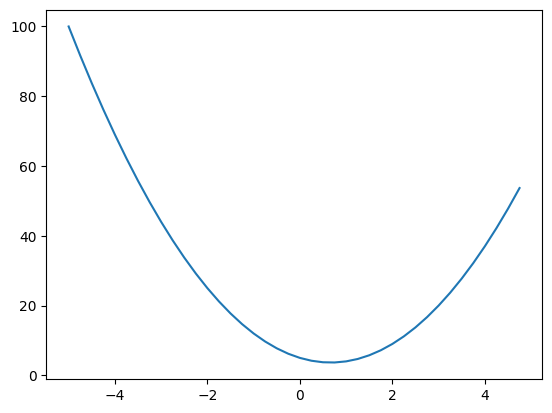

In [111]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

In [112]:
h = 0.00001
x = 3.0
(f(x + h )-f(x))/h

14.00003000000538

Doing the same computation for the value $x=-3$ we should reassess our expectation. What happens in this case?

In [113]:
h = 0.00001
x = 2/3
(f(x + h )-f(x))/h

3.0000002482211127e-05

We need a new data structure to deal with neural networks.

In [ ]:
class Value:
    
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward()
        
        return out
    
    def __mul__(self, other):
        
        out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
            
            self.grad = other.data * self.grad
            other.grad = self.data * other.grad

        out._backward = _backward() 

        return out
    

    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad (1 - t**2) * out.grad 
        
        out._backward = _backward()

        return out


In [328]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = '{ %s | data %.4f | grad %.4f}' % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op) 

    return dot

In [329]:
draw_dot(L)

NameError: name 'L' is not defined

The goal is to do propagation now.


What happens when we change $L$ with respect to $L$.

We need the chain rule if we want to understand $\frac{\partial L}{\partial c}$. The chain  

In [66]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0

c.grad = -2.0
e.grad = -2.0

a.grad = (-2.0 * -3.0)
b.grad = (-2.0 * 2.0)

In [76]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)


-3.9311360000000013


In [ ]:
def lol():
    
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f  = Value(-2.0, label='f')
    L = d * f; L.label = "L"
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f  = Value(-2.0, label='f')
    L = d * f; L.label = "L"
    L2 = L.data 

    print((L2-L1)/h)

lol()

6.000000000021544


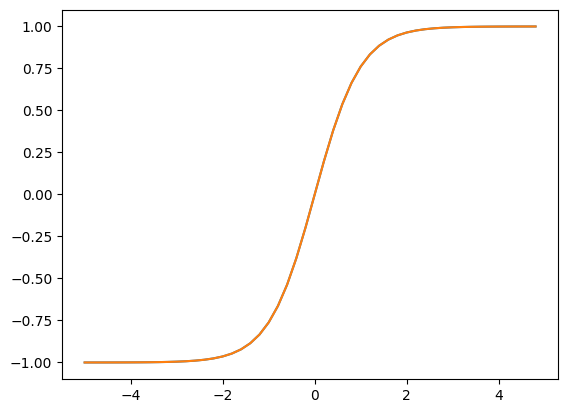

In [79]:
plt.plot(np.arange(-5, 5, .2), np.tanh(np.arange(-5,5,0.2))); plt.grid(); plt.show()

In [363]:
class Value:
    
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        
        out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    

    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad 
        
        out._backward = _backward

        return out
    

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.append(v)
                for child in v._prev:
                    build_topo(v)
                topo.append(v)
        topo = build_topo(self)

        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward() 

In [337]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh()
o.label = 'o'





topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

topo


[Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

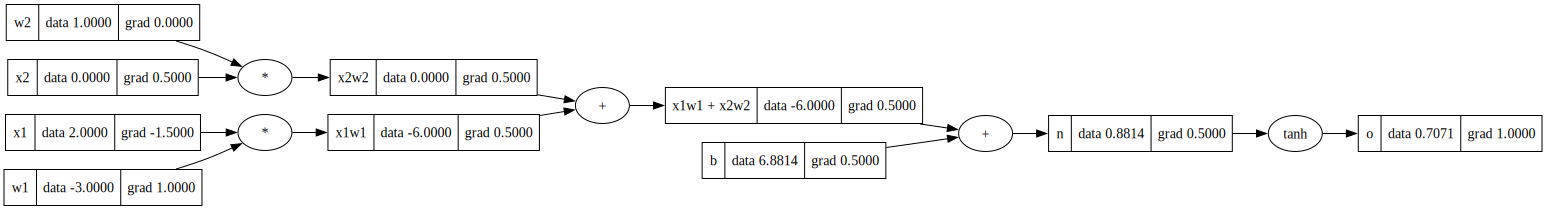

In [184]:
draw_dot(o)

In [179]:
o.grad = 1.0

o._backward()



In [180]:
n._backward()

In [181]:

b._backward()

In [182]:
x1w1x2w2._backward()

In [183]:
x1w1._backward()
x2w2._backward()



$\frac{\partial \mathsf{tanh}}{\partial x} = 1- \mathsf{tanh}(x)^2$ 

We are now done with manually backpropagating and automate.

In [369]:
class Value:
    
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        
        out = Value(self.data * other.data, (self, other), '*')
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    

    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad 
        
        out._backward = _backward

        return out
    

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.append(v)
                for child in v._prev:
                    build_topo(v)
                topo.append(v)
        topo = build_topo(self)

        self.grad = Value(1.0)
        
        for node in reversed(topo):
            node._backward() 


class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))


    def __call__(self, x):
        out = sum([wi * xi for wi, xi in zip(self.w, x)])
        act = out.tanh()
        return act
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        acts = [n(x) for n in self.neurons]
        return acts[0] if acts == 1 else acts

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    




In [370]:
x = [Value(2.0), Value(3.0), Value(-1.0)]
n = MLP(3, [4,4,1])

n(x)

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

# Experimenting with Classes

In [50]:
class MyClass:
    """this is an instance of a class"""
    i = 12345




    def f(something):
        return "Hello, world!"
    


class Complex:


    def __init__(self, realpart, imagpart):
        self.r = realpart
        self.i = imagpart

    def __repr__(self):
        return f"Complex({self.r} + i*{self.i})"

    def mult(self,other):
        real = self.r * other.r - self.i * other.i
        imag = self.r * other.i + self.i * other.r

        out = Complex(real,imag)

        return out


In [54]:
x = Complex(12.2,-1.45)
y = Complex(5,-3)

z = x.mult(y)

z

Complex(56.65 + i*-43.849999999999994)

### Exercise 1:

Create a class ```Dog``` with two attributes:
- ```name``` (a string)
- ```age``` (an integer)

Also add a method ```bark()``` that prints "```Woof!```"

In [ ]:
class Dog:

    def __init__(self, name, age):
        self.name = name
        self.age = age

    def bark(self):
        print('Woof!')

### Adding Methods

Modify your ```Dog``` class to add a method ```dog_info()``` that prints the dog's name and age.

In [60]:
class Dog:

    def __init__(self, name, age):
        self.name = name
        self.age = age

    def bark(self):
        print('Woof')
    
    def dog_info(self):
        print(f"{self.name} is {self.age} years old.")

###Exercise 3: Creating a Bank Account



In [71]:
class BankAccount:

    def __init__(self, balance = 0):
        self.balance = balance
    
    def deposit(self, amount):
        self.balance += amount

    def withdraw(self, amount):
        if self.balance >= amount:
            self.balance -= amount
        else:
            print("Nope.")

### Book Class

Create a class ```Book``` with attributes:

- ```title```(string)
- ```author```(string)
- ```pages```(integer)
- ```current_page```(intially 0)

Add methods:
- ```turn_page()```, increases ```current_page``` by 1 doesn´t exceed ```pages```.
- ````book_info()``` prints title, author, and current page.

In [83]:
class Book:
    def __init__(self, title, author, pages, current_page = 0):
        self.title = title
        self.author = author
        self.pages = pages
        self.current_page = current_page


    def turn_page(self):
        if self.current_page < self.pages:
            self.current_page += 1

    def book_info(self):
        print(f"{self.title} by {self.author}, page {self.current_page} of {self.pages}")    

In [85]:
Crossroads = Book("Crossroads", "Jonathan Franzen", 530, 38)

Crossroads.book_info()
Crossroads.turn_page()
Crossroads.book_info()

Crossroads by Jonathan Franzen, page 38 of 530
Crossroads by Jonathan Franzen, page 39 of 530


### Exercise 5

Define two classes: ``Animal`` and ```Cat```. 

```Animal``` shoould have an attriubute 

In [91]:
class Animal:
    """A class of animals which does some stuff that's useful"""
    def __init__(self, species):
        self.species = species

    def make_sound(self):
        print("Some generic animal sound.")

class Cat(Animal):

    def __init__(self):
        super().__init__("Cat")
    
    def make_sound(self):
        print("Meow!") 


### Exercise 6

Create a class ```Rectangle``` with two attributes: 



In [99]:
4

In [100]:
r1 = Rectangle(3, 4)
r2 = Rectangle(2, 6)


r3 = r1 + r2
r3

Rectangle(width=5, height=10)

# Exercise 7: Class and Instance Variables

Create a class ``Person`` with a class variable ``species`` set to ``"Homo Sapiens"`` and instance variables ``name`` and ``age``.

Create a method ``introduce()`` that prints a short introduction.

In [193]:
class Person:

    species = "Homo sapiens" 
    
    def __init__(self, name, age):
        self.age = age
        self.name = name

    def introduce(self):
        return f"Hello, I'm {self.name}, I'm {self.age} and I'm a {self.species
                                                                   }" 


In [194]:
alice = Person("Alice", 28)
alice.introduce()

"Hello, I'm Alice, I'm 28 and I'm a Homo sapiens"

This exercise draws a distinction between variables which are associated to every member of the class, irrespective of their instantiation method; and instance variables, which possibly change with every instantiation of the class.

# Composition of classes

Construct the following 

In [230]:
class Engine:
    def start(self):
        print("Engine started!")

class Car:
    def __init__(self, engine):
        self.engine = engine 
    def start_car(self):
        self.engine.start()




This is interesting... Potentially very useful. 

It feels like you are chaining classes. Let's say you have some class A and some class B: what we are doing is defining methods for objects of class B which depend on methods of class A.

This is not inheritance, as we discussed above, because not every object of class B is implicitly of class A.

In [231]:
engine = Engine()
car = Car(engine)
car.start_car()

Engine started!


In [277]:
class Item:

    def __init__(self, name, price):

        self.name = name  
        self.price = price

class Inventory:

    def __init__(self, items = []):

        self.items = []


    def add_item(self, item):
        self.items.append(item)

    def remove_item(self,item):
        self.items.remove(item)
        
    def list_items(self):
        for item in self.items:
            print(f"-{item.name} (${item.price})\t")

This exercise taugth me that: mutable default arguments ``(items = [])`` will persist over instances, which is, more often than not, a bug not a feature.

Taking that into consideration, here's a better version of the above code:

In [ ]:
class Item:

    def __init__(self, name, price):

        self.name = name  
        self.price = price

class Inventory:

    def __init__(self):

        self.items = []


    def add_item(self, item):
        self.items.append(item)

    def remove_item(self,item):
        self.items.remove(item)

    # we can a method here which removes an item 
    # by name, which is much more user-friendly
        
    def list_items(self):
        for item in self.items:
            print(f"-{item.name} (${item.price})\t")

In [278]:
item1 = Item("Sword", 100)
item2 = Item("Shield", 150)


In [285]:
new_inventory = Inventory([])
new_inventory.list_items()
new_inventory.add_item(item1)
new_inventory.add_item(item2)
new_inventory.remove_item(item2)
new_inventory.remove_item(item1)

new_inventory.list_items()



# Increased difficulty


Extend the previous BankAccount class:
- Add an attribute ``account_holder``.
- Implement transaction history as a list of tuples: ``("deposit"/"withdraw", amount)``.
- Add a method ``get_statement()`` that neatly prints the transaction history.


In [325]:
class BankAccount:

    def __init__(self, account_holder, balance = 0):
        self.balance = balance
        self.account_holder = account_holder
        self.tran_hist = []


        

    def deposit(self, amount):
        self.balance += amount
        self.tran_hist.append(("deposit", amount))

    def withdraw(self, amount):
        if self.balance >= amount:
            self.balance -= amount
            self.tran_hist.append(("withdraw", amount))
        else:
            print("Nope.")

    def get_statement(self):
        print(f"Account holder: {self.account_holder}\t") 
        print(f"Here's your statement:\t")
        for trans, amount in self.tran_hist:
            print(f"-{trans}: ${amount:.2f}\t")
        print( f"Current balance: ${self.balance:.2f}")

In [326]:
import random

acc = BankAccount("Alice")
acc.deposit(200)
acc.withdraw(50)
for _ in range(10):
    coin = random.randint(0,1)
    amount = random.uniform(0,250)
    if coin == 0:
        acc.deposit(amount)
    else: 
        acc.withdraw(amount)
acc.get_statement()

Nope.
Nope.
Nope.
Nope.
Nope.
Nope.
Nope.
Account holder: Alice	
Here's your statement:	
-deposit: $200.00	
-withdraw: $50.00	
-withdraw: $146.33	
-deposit: $100.31	
-deposit: $31.98	
Current balance: $135.96


# Exercise 12: Deck of Cards

Create two classes: Card and Deck.

- Card should have attributes suit and rank (e.g., "Hearts", "Ace").

- Deck should contain a full set of 52 playing cards.

- Implement methods:

    - shuffle() randomly shuffles the deck.

    - draw_card() removes and returns a card from the deck.

    - cards_left() returns how many cards are remaining.

In [107]:
import itertools
import random


class Card:

    def __init__(self, suit, rank):
            
        suits = ["Hearts", "Spades", "Clubs", "Diamonds"]
        ranks = ("Ace",2,3,4,5,6,7,8,9,10,"Joker", "Queen", "King")

        self.suit = suit
        if self.suit not in suits:
            return f"{self.suit} is an invalid suit."
        else: self.rank = rank
        if self.rank not in list(ranks):
            return f"{self.rank} is an invalid rank."
        else: self.suit = suit
        
    def __repr__(self):
            return f"Card({self.suit},{self.rank})"
    



class Deck:
    

    def __init__(self):
        suits = ["Hearts", "Spades", "Clubs", "Diamonds"]
        ranks = ("Ace",2,3,4,5,6,7,8,9,10,"Joker", "Queen", "King")

        self.unordered_deck = [Card(suit, rank) for suit, rank in list(itertools.product(suits, ranks))]
     
     # You have to order the deck the first time
     # otherwise, one could assume that the 
     # the standard deck ordering applies (if it was not 
     # for the fact that there is no standard ordering)  
    def order(self):
         self.ord_deck = random.sample(self.unordered_deck, k = len(self.unordered_deck))


    def shuffle(self):
        self.ord_deck = random.sample(self.ord_deck, k = len(self.ord_deck))
        return self.ord_deck 

    def draw_card(self):
        pick = random.choice(self.ord_deck)
        self.ord_deck.remove(pick)
        return pick

    def cards_left(self):
        if len(self.ord_deck) == 0:
            print("No more cards to draw.")
        else: return len(self.ord_deck)


In [108]:

deck = Deck()


deck.unordered_deck
deck.order()
deck.ord_deck


[Card(Diamonds,4),
 Card(Clubs,8),
 Card(Spades,5),
 Card(Diamonds,2),
 Card(Diamonds,5),
 Card(Hearts,10),
 Card(Hearts,8),
 Card(Spades,6),
 Card(Clubs,9),
 Card(Clubs,4),
 Card(Hearts,Joker),
 Card(Hearts,King),
 Card(Clubs,3),
 Card(Hearts,2),
 Card(Hearts,5),
 Card(Clubs,Joker),
 Card(Clubs,5),
 Card(Spades,2),
 Card(Spades,King),
 Card(Diamonds,8),
 Card(Spades,Queen),
 Card(Clubs,7),
 Card(Diamonds,Queen),
 Card(Diamonds,3),
 Card(Spades,9),
 Card(Clubs,2),
 Card(Diamonds,King),
 Card(Clubs,Queen),
 Card(Diamonds,Joker),
 Card(Spades,10),
 Card(Spades,3),
 Card(Clubs,King),
 Card(Clubs,6),
 Card(Clubs,Ace),
 Card(Hearts,9),
 Card(Hearts,4),
 Card(Diamonds,10),
 Card(Spades,Ace),
 Card(Hearts,Queen),
 Card(Diamonds,7),
 Card(Diamonds,6),
 Card(Diamonds,9),
 Card(Spades,Joker),
 Card(Clubs,10),
 Card(Hearts,6),
 Card(Hearts,7),
 Card(Spades,8),
 Card(Hearts,Ace),
 Card(Diamonds,Ace),
 Card(Hearts,3),
 Card(Spades,7),
 Card(Spades,4)]

In [110]:
new_deck = Deck()
new_deck.order()

for _ in range(51):
    new_deck.draw_card()

In [111]:
new_deck.draw_card()

Card(Spades,4)

In [113]:
random.randint(1,30)

3

# Exercise 13: A Library System 


In [ ]:
class Book:

    def __init__(self, title, author, ISBN, available):
        self.title = title
        self.author = author 
        self.ISBN = ISBN
        self.available = available

class Member:

    def __init__(self, name, member_ID, books_borrowed):
        self.name = name
        self.member_ID = memb 

# Exercise 14: Polymorphism and Inheritance

*Inhheritance:* It is all about building on top of another class.

The base class, in this case ``Shape`` controls the Rectangle, Triangle, and Circle classes. They all share the fact thaey have area and perimeter. 

*Polymorphism:* Same interface, different behaviour.

For polymorphism to be deployed in Python, the code ``Pass`` is the right placeholder to include in unspecified methods, like the one in the example below.



In [117]:
import math

class Shape:
    
    def area(self):
        pass 
    
    def perimeter(self):
        pass
    

class Circle(Shape):

    def __init__(self, radius):
        self.radius = radius

    def area(self):
        self.area = (self.radius ** 2) * math.pi
        return self.area

    def perimeter(self):
        self.perimeter = self.radius * 2 * math.pi
        return self.perimeter
    


    


In [120]:
circle = Circle(1)

circle.perimeter()


6.283185307179586

: 

In [ ]:
class TicTacToe:

    def __init__(self):
        self.board = [[],[],[]]

    def check_score(self):
        
        sum_row = 0
        i = 0
        while sum_row != 3 or sum_row != -3 or i == 2:
            sum_row = sum(self.board[i]) 
            i += 1
        

        
        
    def make_move(self, x,y):
        
        self.board[x,y] = 1
        if self.check_score() == 0:




